In [1]:
%pylab inline
from argparse import Namespace
from marcos import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
args = Namespace(
    batch = 60000,
    seed = RANDOM_SEED,
    task = 'repeat-copy',
    seq_width = 8,
    ctrl_size = 100,
    ctrl_num_layers = 1,
    mem_size = 128,
    mem_dim = 20,
    num_heads = 1,
    batch_size = 1,
    mark = 'fix',
)
init_seed(args.seed)


task = TaskRepeatCopy(vars(args),'eval')
print(task.net)

repeat-copy
log/repeat-copy/fix/60000.model
NTM(
  (controller): LSTMController(
    (lstm): LSTM(28, 100)
  )
  (memory): NTMMemory()
  (heads): ModuleList(
    (0): NTMReadHead(
      (memory): NTMMemory()
      (fc_read): Linear(in_features=100, out_features=26, bias=True)
    )
    (1): NTMWriteHead(
      (memory): NTMMemory()
      (fc_write): Linear(in_features=100, out_features=66, bias=True)
    )
  )
  (fc): Linear(in_features=28, out_features=8, bias=True)
)


In [23]:
NUM_REP = 1
SEQ_LEN = 10
memory_ls = list()
TOT_LEN = SEQ_LEN + 2 + (SEQ_LEN*NUM_REP)+3
read_weights = torch.Tensor(TOT_LEN,args.mem_size)
write_weights = torch.Tensor(TOT_LEN,args.mem_size)

for X,y in task._data_gen(1,1,NUM_REP,SEQ_LEN):
    pred = torch.Tensor(y.size())
    task.net.init(1)
    memory_ls.append(task.net.memory.get_memory().t())
    
    for i in range(SEQ_LEN+2):
        _,prev_state = task.net(X[i])
        read_weights[i] = prev_state[2][0]
        write_weights[i] = prev_state[2][1]
        
    memory_ls.append(task.net.memory.get_memory().t())
    
    for o in range(SEQ_LEN*NUM_REP+3):
        pred[o],prev_state = task.net(torch.zeros(1,task.seq_width))
        read_weights[o+SEQ_LEN+2] = prev_state[2][0]
        write_weights[o+SEQ_LEN+2] = prev_state[2][1]
    memory_ls.append(task.net.memory.get_memory().t())
    y = torch.transpose(y,0,2)
    pred = torch.transpose(pred,0,2)

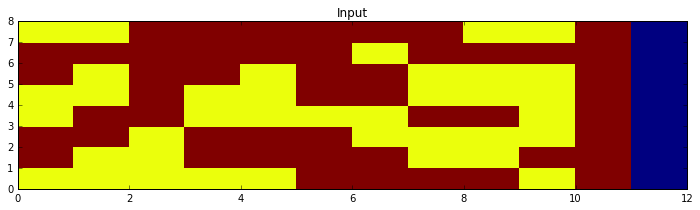

In [24]:
plt.figure(figsize=(12, 3))
plt.title("Input")
X = torch.transpose(X,0,2)
pcolormesh(X.squeeze(1).data.numpy())

Cost per byte: 4.5


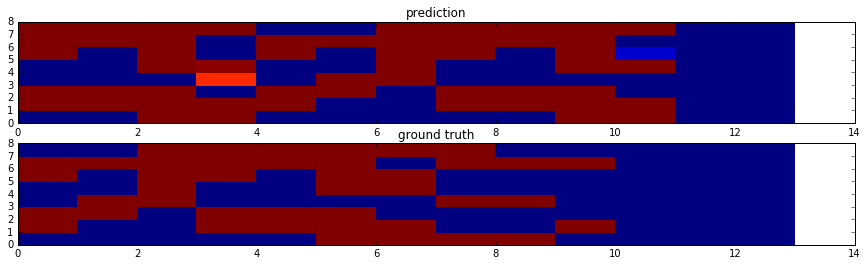

In [25]:
plt.figure(figsize=(15, 4))
plt.subplot(2,1, 1)
plt.title("prediction")
pcolormesh(pred.squeeze(1).data.numpy())
plt.subplot(2,1, 2)
plt.title("ground truth")
pcolormesh(y.squeeze(1).data.numpy())
print("Cost per byte: {}".format(torch.sum(torch.abs(torch.round(pred)-y))/(SEQ_LEN)))